# Toy Problem Case Study: Tokenization Effects in VLA Training

This notebook reproduces the case study from the paper that demonstrates how naive tokenization schemes affect the training of autoregressive vision-language-action (VLA) policies at different sampling rates.

## Overview

The case study reproduces the key findings from the paper showing that:

1. **Naive binning tokenization** works well at low sampling rates (H=25-50)
2. **Performance degrades significantly** at high sampling rates (H=400-800)
3. **Marginal information content approaches zero** as sampling frequency increases
4. **Models tend to copy the first action** at high frequencies instead of learning meaningful patterns

This demonstrates the need for better tokenization schemes like the DCT-based FAST tokenization proposed in the paper.


## Setup and Imports


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Dict, List

# Set up matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Import our modules
from cubic_spline_generator import CubicSplineGenerator
from binning_tokenizer import BinningTokenizer
from transformer_model import SimpleTransformer, count_parameters
from training import Trainer, run_experiment
from visualization import CaseStudyVisualizer

print("Setup complete!")


Setup complete!


## 1. Demonstrate the Tokenization Issue

First, let's demonstrate the core tokenization issue described in the paper.


In [2]:
# Initialize components
generator = CubicSplineGenerator(seed=42)
tokenizer = BinningTokenizer(num_bins=256)

# Test different sampling rates
sampling_rates = [25, 50, 100, 200, 400, 800]

print("Analyzing marginal information content:")
print("Sampling Rate | Entropy | Zero Diff Ratio | Unique Diffs")
print("-" * 60)

results = {}

for H in sampling_rates:
    # Generate data
    times, targets, conditioning = generator.generate_spline_data(
        num_sequences=100,
        sequence_length=H
    )

    # Fit tokenizer
    tokenizer.fit(targets)

    # Analyze marginal information
    analysis = tokenizer.analyze_marginal_information(targets, H)
    results[H] = analysis

    print(f"{H:13d} | {analysis['entropy']:7.3f} | {analysis['zero_diff_ratio']:13.3f} | {analysis['unique_diffs']:11d}")


Analyzing marginal information content:
Sampling Rate | Entropy | Zero Diff Ratio | Unique Diffs
------------------------------------------------------------
[4.24724071 3.2227761  2.20558569 ... 3.94000719 4.26493663 4.5666388 ]
Fitted tokenizer with range [-7.974, 7.958]
Bin width: 0.062
           25 |   6.102 |         0.012 |         117
[6.71807009 6.43193265 6.14512379 ... 4.79495235 5.67402229 6.55638957]
Fitted tokenizer with range [-7.997, 7.996]
Bin width: 0.062
           50 |   5.035 |         0.032 |          69
[4.08405996 3.68591631 3.28874478 ... 3.90641131 4.33755793 4.77029686]
Fitted tokenizer with range [-7.997, 7.905]
Bin width: 0.062
          100 |   4.087 |         0.068 |          34
[3.64442954 3.32948827 3.01486847 ... 2.91914372 2.94025162 2.96135361]
Fitted tokenizer with range [-8.000, 7.997]
Bin width: 0.062
          200 |   3.086 |         0.134 |          16
[2.50476597 2.35909698 2.21351725 ... 4.89758626 5.08880525 5.28006359]
Fitted tokenizer with 

### Visualize the Tokenization Issue


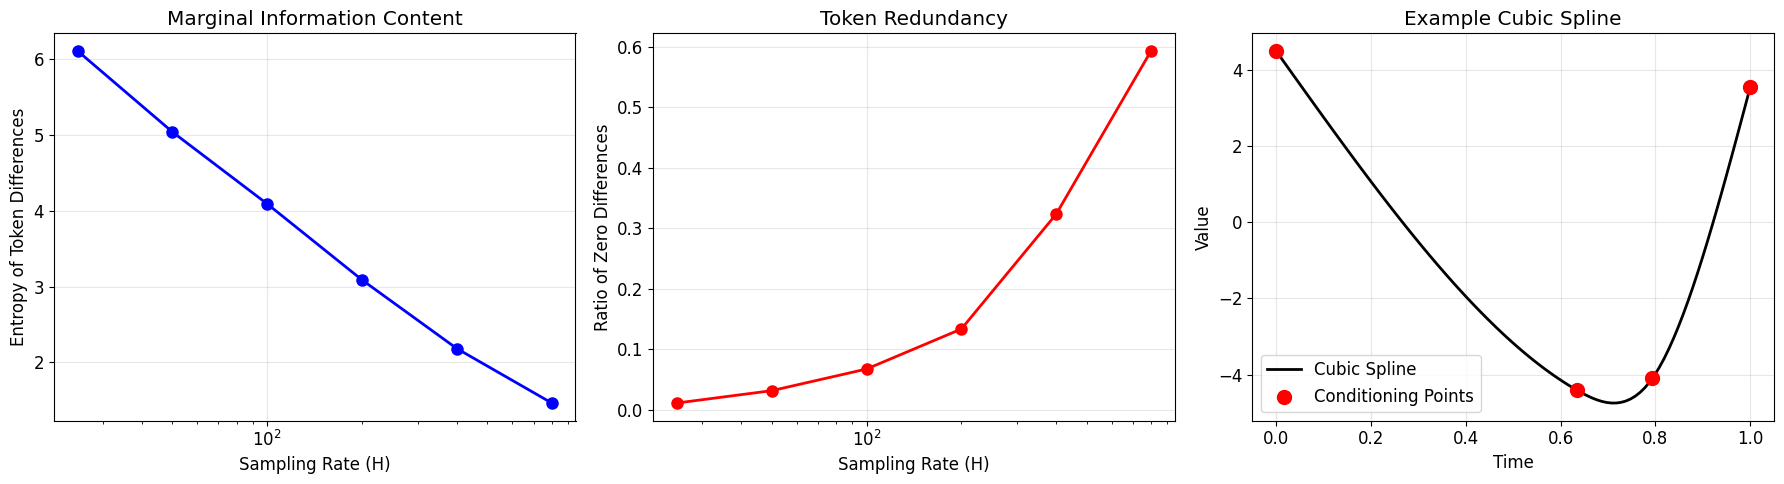


KEY INSIGHTS
1. ENTROPY DECREASES with sampling rate:
   H=25:  6.102
   H=800: 1.466
   Reduction: 76.0%

2. TOKEN REDUNDANCY INCREASES with sampling rate:
   H=25:  0.012 zero differences
   H=800: 0.593 zero differences
   Increase: 4980.1%

3. UNIQUE DIFFERENCES DECREASE with sampling rate:
   H=25:  117 unique differences
   H=800: 7 unique differences
   Reduction: 94.0%


In [3]:
# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Entropy vs Sampling Rate
axes[0].plot(sampling_rates, [results[H]['entropy'] for H in sampling_rates], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Sampling Rate (H)')
axes[0].set_ylabel('Entropy of Token Differences')
axes[0].set_title('Marginal Information Content')
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# Plot 2: Zero Difference Ratio vs Sampling Rate
axes[1].plot(sampling_rates, [results[H]['zero_diff_ratio'] for H in sampling_rates], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Sampling Rate (H)')
axes[1].set_ylabel('Ratio of Zero Differences')
axes[1].set_title('Token Redundancy')
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

# Plot 3: Example spline at different sampling rates
# Generate a single example spline
times, targets, conditioning = generator.generate_spline_data(
    num_sequences=1,
    sequence_length=100  # Use medium sampling rate for visualization
)

axes[2].plot(times[0], targets[0], 'k-', linewidth=2, label='Cubic Spline')
axes[2].scatter(conditioning[0, :, 0], conditioning[0, :, 1],
               color='red', s=100, zorder=5, label='Conditioning Points')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Value')
axes[2].set_title('Example Cubic Spline')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
print("\n" + "=" * 60)
print("KEY INSIGHTS")
print("=" * 60)
print("1. ENTROPY DECREASES with sampling rate:")
print(f"   H=25:  {results[25]['entropy']:.3f}")
print(f"   H=800: {results[800]['entropy']:.3f}")
print(f"   Reduction: {(1 - results[800]['entropy']/results[25]['entropy'])*100:.1f}%")

print("\n2. TOKEN REDUNDANCY INCREASES with sampling rate:")
print(f"   H=25:  {results[25]['zero_diff_ratio']:.3f} zero differences")
print(f"   H=800: {results[800]['zero_diff_ratio']:.3f} zero differences")
print(f"   Increase: {(results[800]['zero_diff_ratio']/results[25]['zero_diff_ratio'] - 1)*100:.1f}%")

print("\n3. UNIQUE DIFFERENCES DECREASE with sampling rate:")
print(f"   H=25:  {results[25]['unique_diffs']} unique differences")
print(f"   H=800: {results[800]['unique_diffs']} unique differences")
print(f"   Reduction: {(1 - results[800]['unique_diffs']/results[25]['unique_diffs'])*100:.1f}%")

## 2. Run the Training Experiment

Now let's run the actual training experiment to see how the model performance degrades with sampling rate.


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create results directory
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Initialize visualizer
visualizer = CaseStudyVisualizer(device)

print("Setup complete for training experiment!")


Using device: cuda
Setup complete for training experiment!


### Quick Test

Let's start with a test to demonstrate the effect.


In [11]:
# Run quick experiment
print("Running quick experiment with reduced parameters...")
print("Sampling rates: [25, 100, 400]")
print("Sequences: 200, Epochs: 20")

quick_results = run_experiment(
    sampling_rates=[50],
    num_sequences=10000,  # Smaller for faster testing
    num_epochs=100,      # Fewer epochs for faster testing
    results_dir=results_dir
)

print("\n" + "=" * 60)
print("QUICK EXPERIMENT RESULTS")
print("=" * 60)
print("Sampling Rate (H) | MSE")
print("-" * 30)
for H in sorted(quick_results.keys()):
    print(f"{H:15d} | {quick_results[H]:.6f}")


Running quick experiment with reduced parameters...
Sampling rates: [25, 100, 400]
Sequences: 200, Epochs: 20
Using device: cuda

Training with sampling rate H = 50
[4.24724071 3.74501077 3.24363556 ... 3.63395942 4.03640939 4.43963452]
Fitted tokenizer with range [-8.000, 8.000]
Bin width: 0.062
Epoch   0: Train Loss = 4.160820, Val Loss = 3.238932, Time = 2.93s
Epoch  10: Train Loss = 1.410077, Val Loss = 1.271965, Time = 2.88s
Epoch  20: Train Loss = 1.150368, Val Loss = 1.040154, Time = 2.84s
Epoch  30: Train Loss = 1.043482, Val Loss = 0.902858, Time = 2.81s
Epoch  40: Train Loss = 0.977543, Val Loss = 0.881210, Time = 2.84s
Epoch  50: Train Loss = 0.939319, Val Loss = 0.854872, Time = 2.82s
Epoch  60: Train Loss = 0.904536, Val Loss = 0.820116, Time = 2.84s
Epoch  70: Train Loss = 0.888254, Val Loss = 0.844902, Time = 2.81s
Epoch  80: Train Loss = 0.864401, Val Loss = 0.848115, Time = 2.84s
Epoch  90: Train Loss = 0.839625, Val Loss = 0.775632, Time = 2.88s
H = 50: MSE = 8.872535

### Visualize Results


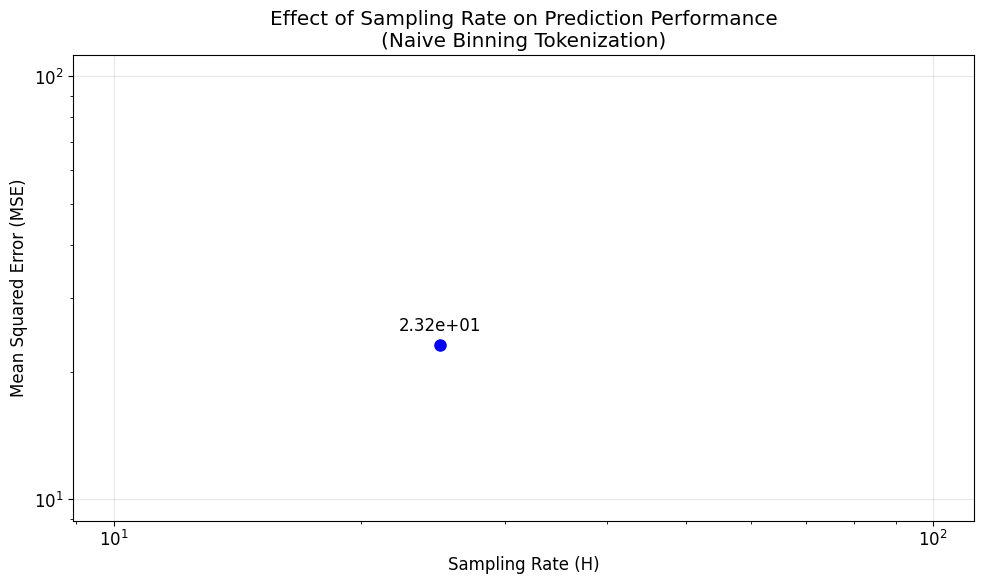


Expected behavior:
- H=25: Good performance (low MSE)
- H=100: Moderate performance
- H=400: Poor performance (high MSE)

This demonstrates the tokenization issue described in the paper!


In [6]:
# Plot the results
sampling_rates_quick = sorted(quick_results.keys())
mse_values = [quick_results[H] for H in sampling_rates_quick]

plt.figure(figsize=(10, 6))
plt.plot(sampling_rates_quick, mse_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Sampling Rate (H)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Effect of Sampling Rate on Prediction Performance\n(Naive Binning Tokenization)')
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.yscale('log')

# Add annotations
for H, mse in zip(sampling_rates_quick, mse_values):
    plt.annotate(f'{mse:.2e}', (H, mse),
                textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

print("\nExpected behavior:")
print("- H=25: Good performance (low MSE)")
print("- H=100: Moderate performance")
print("- H=400: Poor performance (high MSE)")
print("\nThis demonstrates the tokenization issue described in the paper!")


Generating trajectory visualizations...
[ 6.01136264  4.17371959  2.37269747  0.64491721 -0.97300026 -2.44443402
 -3.73276313 -4.80199494 -5.64425384 -6.29048182 -6.77445932 -7.12996676
 -7.39078457 -7.59007739 -7.74572258 -7.8596581  -7.93307565 -7.96716695
 -7.9631237  -7.9221376  -7.84540035 -7.73410367 -7.58943925 -7.41259881
 -7.20477404 -6.96715665 -6.70093834 -6.40731083 -6.08746581 -5.74259499
 -5.37389007 -4.98254276 -4.56974477 -4.1366878  -3.68456355 -3.21456373
 -2.72788004 -2.22570419 -1.70922788 -1.17964282 -0.63814071 -0.08591326
  0.47584784  1.04595086  1.62320411  2.20641589  2.79439448  3.38594819
  3.97988531  4.57501414]
Fitted tokenizer with range [-7.967, 6.011]
Bin width: 0.055


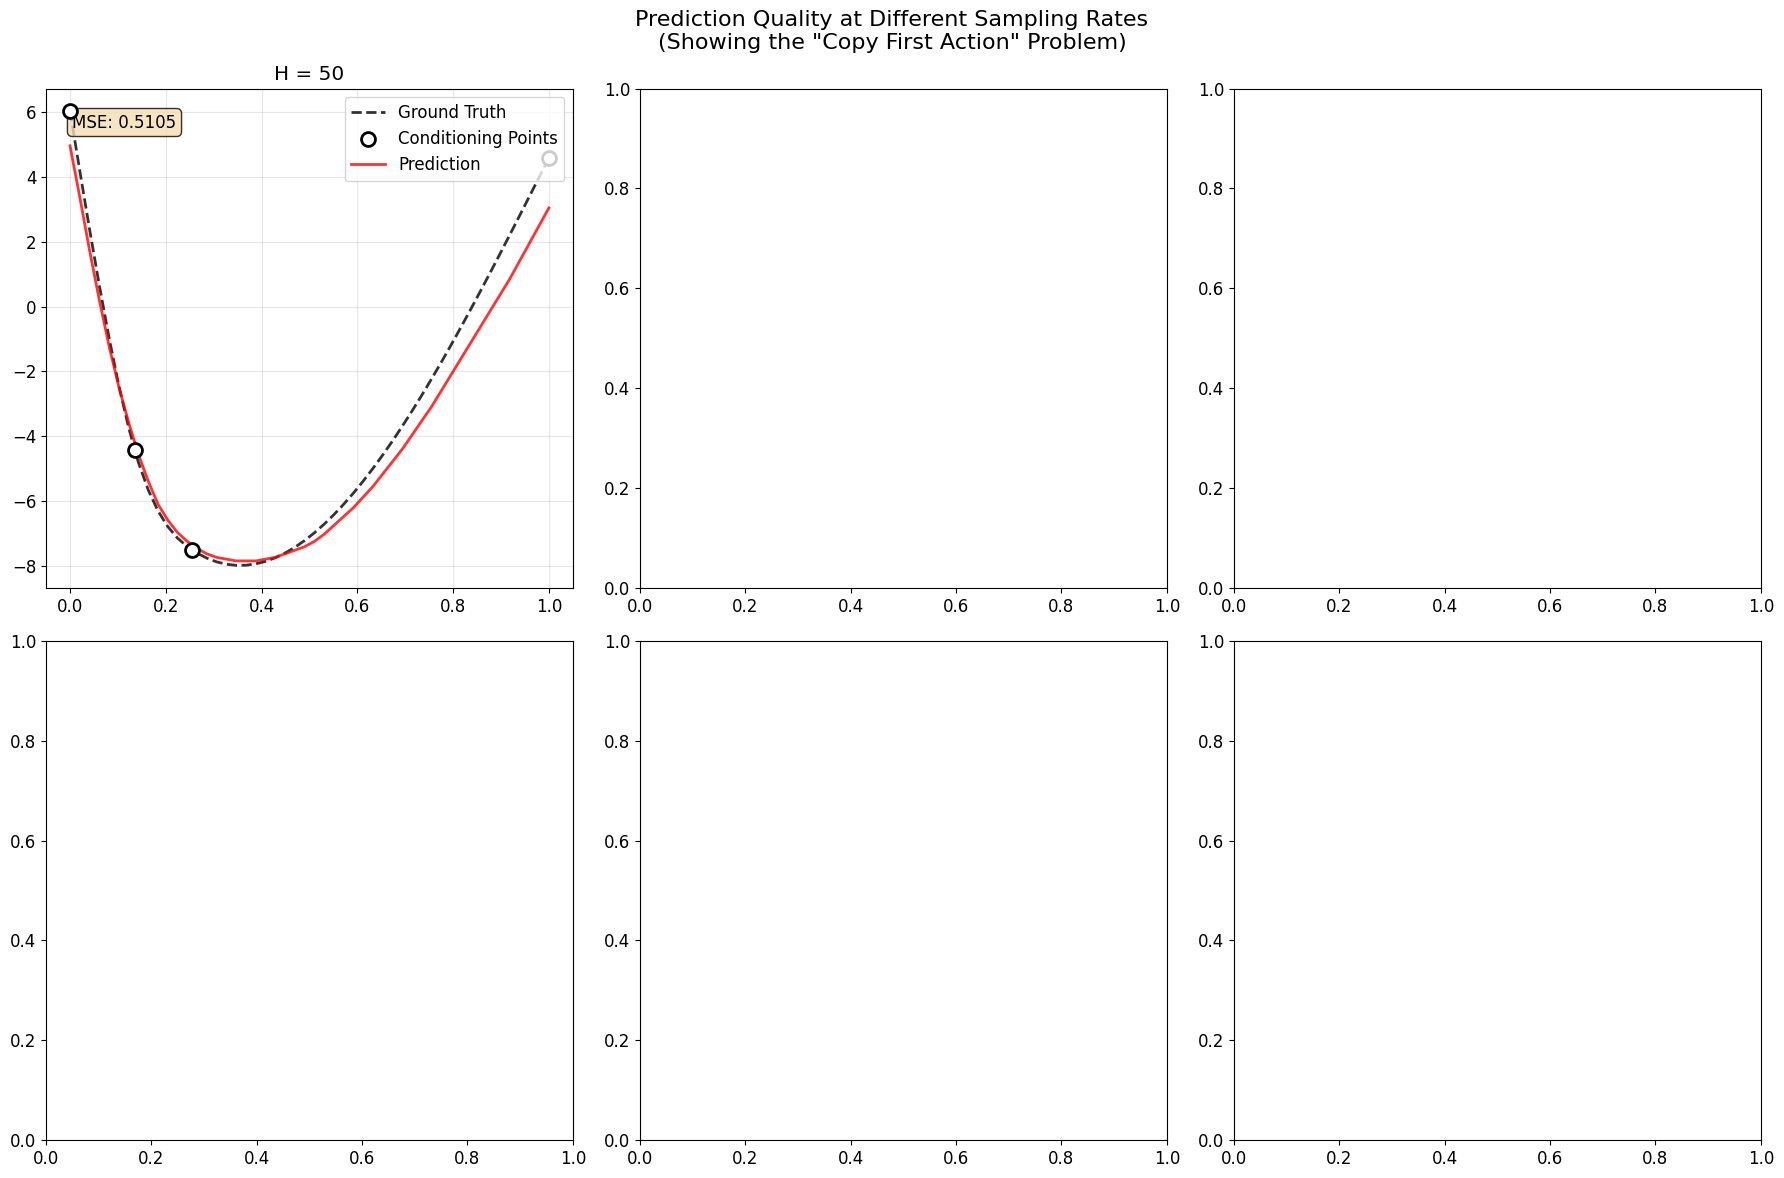


Key observations:
- Low H (25, 50): Model learns to interpolate the smooth curve
- Medium H (100, 200): Some degradation but still reasonable
- High H (400, 800): Model tends to copy the first action or produce poor predictions
- This demonstrates the tokenization issue described in the paper!


In [20]:
# Visualize prediction trajectories for different sampling rates
print("Generating trajectory visualizations...")

# Create a comprehensive visualization showing prediction quality at different frequencies
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Test different sampling rates
test_sampling_rates = [50]

for i, H in enumerate(test_sampling_rates):
    ax = axes[i]

    # Generate test data
    generator_test = CubicSplineGenerator(seed=31)  # Different seed for variety
    times, targets, conditioning = generator_test.generate_spline_data(
        num_sequences=1,
        sequence_length=H
    )

    # Try to load the trained model for this sampling rate
    model_path = os.path.join(results_dir, f"model_H{H}.pth")

    if os.path.exists(model_path):
        # Load model
        model = SimpleTransformer(
            vocab_size=256,
            d_model=128,
            nhead=8,
            num_layers=4,
            max_seq_len=H + 100
        )
        model.load_state_dict(torch.load(model_path, map_location=device))
        model = model.to(device)
        model.eval()

        # Fit tokenizer
        tokenizer_test = BinningTokenizer(num_bins=256)
        tokenizer_test.fit(targets)

        # Generate predictions
        with torch.no_grad():
            conditioning_tensor = torch.from_numpy(conditioning).float().to(device)
            predicted_tokens = model.generate(
                conditioning_tensor,
                max_length=H,
                greedy=True,  # Deterministic generation using argmax
                device=device
            )

        # Convert predictions back to continuous values
        predicted_values = tokenizer_test.detokenize(predicted_tokens.cpu().numpy())

        # Plot ground truth
        ax.plot(times[0], targets[0], 'k--', linewidth=2, label='Ground Truth', alpha=0.8)

        # Plot conditioning points
        ax.scatter(conditioning[0, :, 0], conditioning[0, :, 1],
                  color='white', s=100, zorder=5, edgecolors='black', linewidth=2,
                  label='Conditioning Points')

        # Plot prediction
        ax.plot(times[0], predicted_values[0], 'r-', linewidth=2, label='Prediction', alpha=0.8)

        # Compute and display MSE
        mse = np.mean((targets[0] - predicted_values[0]) ** 2)
        ax.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=ax.transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        ax.set_title(f'H = {H}')
        ax.grid(True, alpha=0.3)

        # Only add legend to first subplot
        if i == 0:
            ax.legend(loc='upper right')

    else:
        # If model doesn't exist, just show the ground truth
        ax.plot(times[0], targets[0], 'k--', linewidth=2, label='Ground Truth')
        ax.scatter(conditioning[0, :, 0], conditioning[0, :, 1],
                  color='red', s=100, zorder=5, label='Conditioning Points')
        ax.set_title(f'H = {H} (No trained model)')
        ax.grid(True, alpha=0.3)
        ax.legend()

plt.suptitle('Prediction Quality at Different Sampling Rates\n(Showing the "Copy First Action" Problem)', fontsize=16)
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("- Low H (25, 50): Model learns to interpolate the smooth curve")
print("- Medium H (100, 200): Some degradation but still reasonable")
print("- High H (400, 800): Model tends to copy the first action or produce poor predictions")
print("- This demonstrates the tokenization issue described in the paper!")


In [13]:
# Run quick experiment
print("Running quick experiment with reduced parameters...")
print("Sampling rates: [25, 100, 400]")
print("Sequences: 200, Epochs: 20")

quick_results = run_experiment(
    sampling_rates=[400],
    num_sequences=10000,  # Smaller for faster testing
    num_epochs=100,      # Fewer epochs for faster testing
    results_dir=results_dir
)

print("\n" + "=" * 60)
print("QUICK EXPERIMENT RESULTS")
print("=" * 60)
print("Sampling Rate (H) | MSE")
print("-" * 30)
for H in sorted(quick_results.keys()):
    print(f"{H:15d} | {quick_results[H]:.6f}")

Running quick experiment with reduced parameters...
Sampling rates: [25, 100, 400]
Sequences: 200, Epochs: 20
Using device: cuda

Training with sampling rate H = 400
[4.24724071 4.18554612 4.12385311 ... 4.25185924 4.33638444 4.42091614]
Fitted tokenizer with range [-8.000, 8.000]
Bin width: 0.062
Epoch   0: Train Loss = 3.300524, Val Loss = 0.948471, Time = 20.07s
Epoch  10: Train Loss = 0.422969, Val Loss = 0.375769, Time = 19.82s
Epoch  20: Train Loss = 0.336141, Val Loss = 0.313656, Time = 19.81s
Epoch  30: Train Loss = 0.303034, Val Loss = 0.267782, Time = 19.81s
Epoch  40: Train Loss = 0.279097, Val Loss = 0.243409, Time = 19.83s
Epoch  50: Train Loss = 0.262689, Val Loss = 0.237145, Time = 19.80s
Epoch  60: Train Loss = 0.248855, Val Loss = 0.220552, Time = 19.79s
Epoch  70: Train Loss = 0.238208, Val Loss = 0.231683, Time = 19.79s


KeyboardInterrupt: 

Generating trajectory visualizations...
[ 6.01136264e+00  5.78494893e+00  5.55860305e+00  5.33239282e+00
  5.10638607e+00  4.88065062e+00  4.65525431e+00  4.43026496e+00
  4.20575039e+00  3.98177843e+00  3.75841691e+00  3.53573365e+00
  3.31379649e+00  3.09267324e+00  2.87243174e+00  2.65313980e+00
  2.43486526e+00  2.21767595e+00  2.00163968e+00  1.78682429e+00
  1.57329760e+00  1.36112744e+00  1.15038164e+00  9.41128015e-01
  7.33434399e-01  5.27368617e-01  3.22998496e-01  1.20391861e-01
 -8.03834597e-02 -2.79259641e-01 -4.76168856e-01 -6.71043278e-01
 -8.63815081e-01 -1.05441644e+00 -1.24277952e+00 -1.42883651e+00
 -1.61251957e+00 -1.79376089e+00 -1.97249262e+00 -2.14864695e+00
 -2.32215605e+00 -2.49295209e+00 -2.66096725e+00 -2.82613370e+00
 -2.98838361e+00 -3.14764916e+00 -3.30386252e+00 -3.45695587e+00
 -3.60686137e+00 -3.75351121e+00 -3.89683755e+00 -4.03677257e+00
 -4.17324844e+00 -4.30619734e+00 -4.43555144e+00 -4.56126947e+00
 -4.68339644e+00 -4.80199494e+00 -4.91712752e+00 -

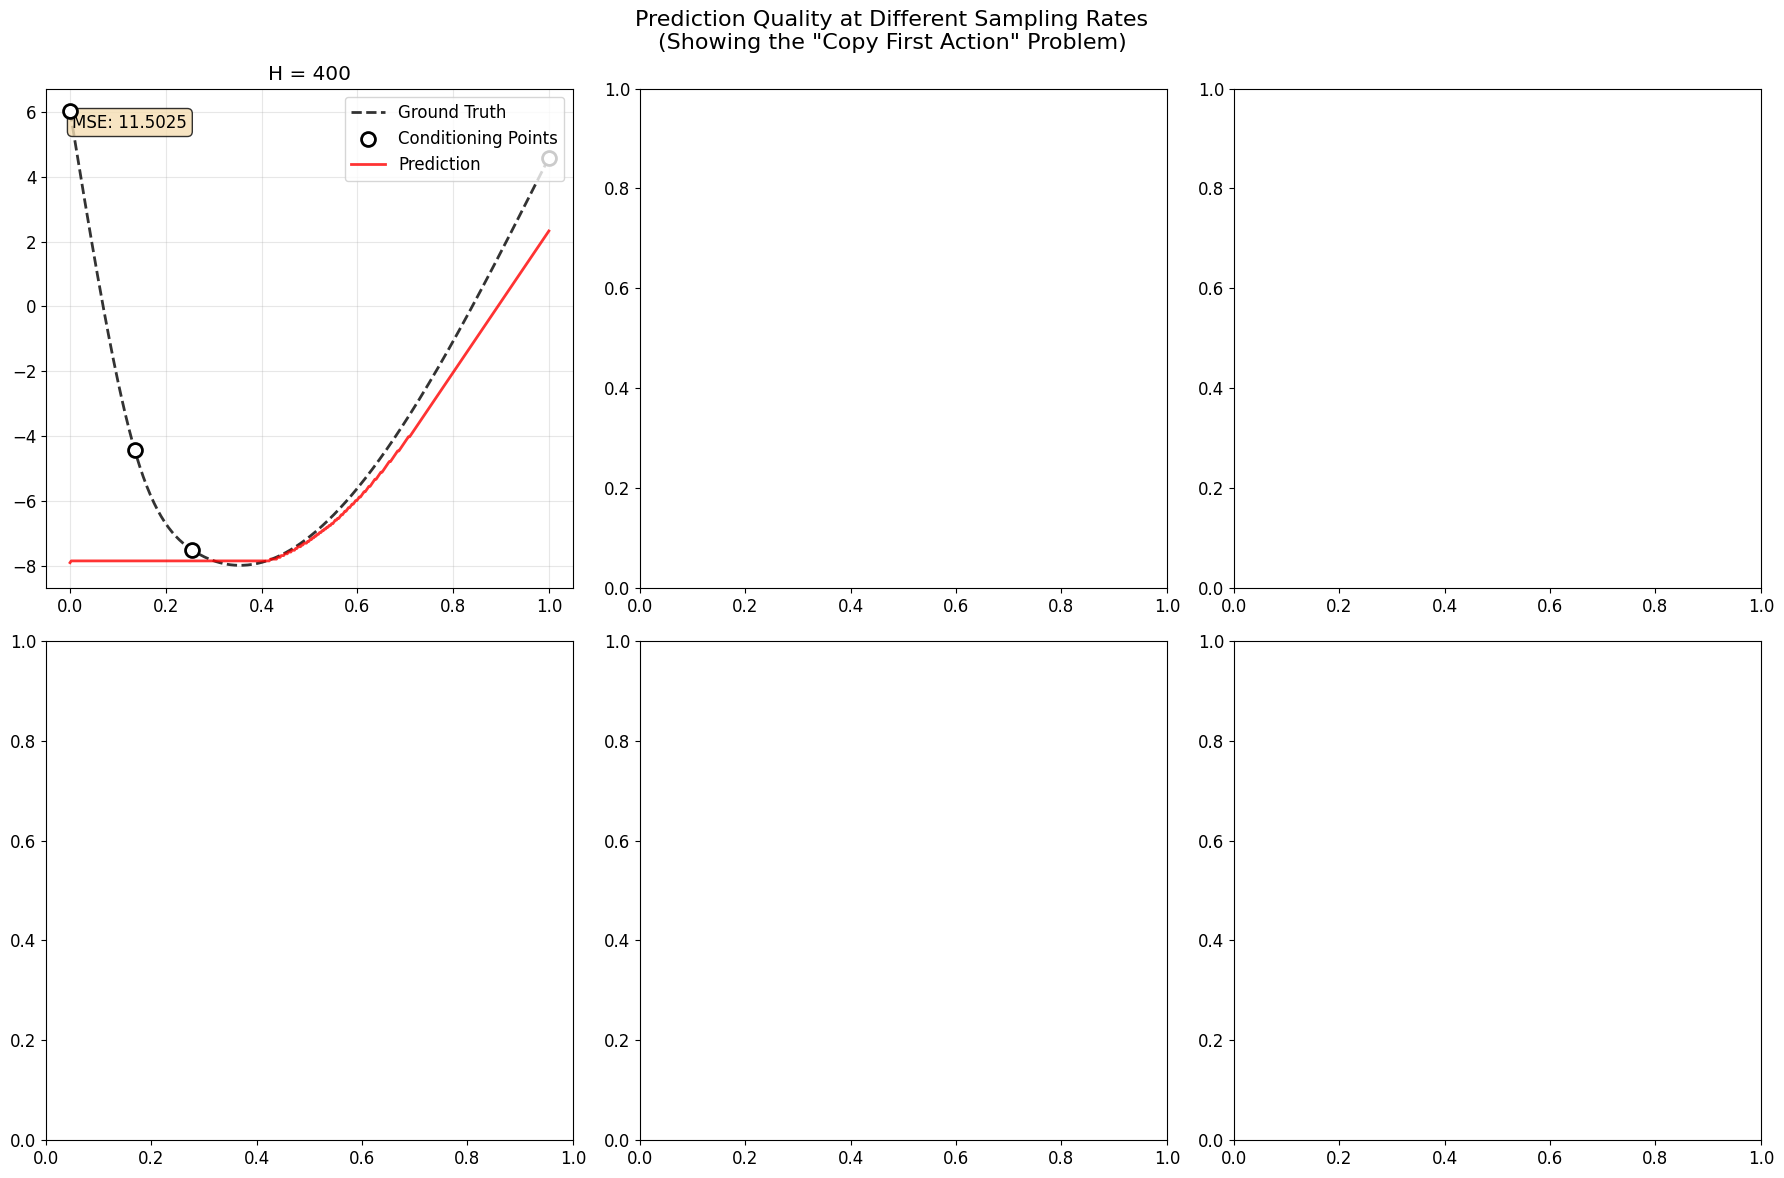


Key observations:
- Low H (25, 50): Model learns to interpolate the smooth curve
- Medium H (100, 200): Some degradation but still reasonable
- High H (400, 800): Model tends to copy the first action or produce poor predictions
- This demonstrates the tokenization issue described in the paper!


In [21]:
# Visualize prediction trajectories for different sampling rates
print("Generating trajectory visualizations...")

# Create a comprehensive visualization showing prediction quality at different frequencies
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Test different sampling rates
test_sampling_rates = [400]

for i, H in enumerate(test_sampling_rates):
    ax = axes[i]

    # Generate test data
    generator_test = CubicSplineGenerator(seed=31)  # Different seed for variety
    times, targets, conditioning = generator_test.generate_spline_data(
        num_sequences=1,
        sequence_length=H
    )

    # Try to load the trained model for this sampling rate
    model_path = os.path.join(results_dir, f"model_H{H}.pth")

    if os.path.exists(model_path):
        # Load model
        model = SimpleTransformer(
            vocab_size=256,
            d_model=128,
            nhead=8,
            num_layers=4,
            max_seq_len=H + 100
        )
        model.load_state_dict(torch.load(model_path, map_location=device))
        model = model.to(device)
        model.eval()

        # Fit tokenizer
        tokenizer_test = BinningTokenizer(num_bins=256)
        tokenizer_test.fit(targets)

        # Generate predictions
        with torch.no_grad():
            conditioning_tensor = torch.from_numpy(conditioning).float().to(device)
            predicted_tokens = model.generate(
                conditioning_tensor,
                max_length=H,
                greedy=True,  # Deterministic generation using argmax
                device=device
            )

        # Convert predictions back to continuous values
        predicted_values = tokenizer_test.detokenize(predicted_tokens.cpu().numpy())

        # Plot ground truth
        ax.plot(times[0], targets[0], 'k--', linewidth=2, label='Ground Truth', alpha=0.8)

        # Plot conditioning points
        ax.scatter(conditioning[0, :, 0], conditioning[0, :, 1],
                  color='white', s=100, zorder=5, edgecolors='black', linewidth=2,
                  label='Conditioning Points')

        # Plot prediction
        ax.plot(times[0], predicted_values[0], 'r-', linewidth=2, label='Prediction', alpha=0.8)

        # Compute and display MSE
        mse = np.mean((targets[0] - predicted_values[0]) ** 2)
        ax.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=ax.transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        ax.set_title(f'H = {H}')
        ax.grid(True, alpha=0.3)

        # Only add legend to first subplot
        if i == 0:
            ax.legend(loc='upper right')

    else:
        # If model doesn't exist, just show the ground truth
        ax.plot(times[0], targets[0], 'k--', linewidth=2, label='Ground Truth')
        ax.scatter(conditioning[0, :, 0], conditioning[0, :, 1],
                  color='red', s=100, zorder=5, label='Conditioning Points')
        ax.set_title(f'H = {H} (No trained model)')
        ax.grid(True, alpha=0.3)
        ax.legend()

plt.suptitle('Prediction Quality at Different Sampling Rates\n(Showing the "Copy First Action" Problem)', fontsize=16)
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("- Low H (25, 50): Model learns to interpolate the smooth curve")
print("- Medium H (100, 200): Some degradation but still reasonable")
print("- High H (400, 800): Model tends to copy the first action or produce poor predictions")
print("- This demonstrates the tokenization issue described in the paper!")
